<p style="font-size:32px; font-weight: bolder; text-align: center"> Atom-centered density correlation representations </p>
<p style="text-align: center"><i> authored by: <a href="mailto:michele.ceriotti@gmail.com"> Michele Ceriotti </a></i></p>

This notebook demonstrates some of the concepts discussed in the second lecture in the "Introduction to Atomic-Scale Machine Learning" mini-course. 
It demonstrates the construction of descriptors of an atom-centered environment based on an expansion of the neighbor density in radial functions 
and spherical harmonics, and how these can be combined to build higher-order invariant and equivariant descriptors. 

The notebook contains examples for a water-molecule dataset, and introduces the concepts of density-correlation descriptors, as well as how their significance in terms of SO(3) equivariance. 

1. [Water dataset](#loading)
1. [Density expansion coefficients](#density-expansion)
2. [Compute the SOAP representation](#soap)
3. [Relation with atom-centered symmetry functions](#variations)
4. [Equivariance and equivariant features](#equivariance)

In [1]:
%matplotlib inline
import numpy as np
import ase, ase.io
import matplotlib as mpl
import matplotlib.pyplot as plt 
import itertools

import chemiscope

import rascaline
import sphericart as sc
import metatensor as mt
from metatensor import mean_over_samples, Labels

from skmatter.metrics import global_reconstruction_error, local_reconstruction_error

# loads some utilities from a helper file
from utils import wigner_d_matrix, wigner_d_real, rotation_matrix, xyz_to_spherical, spherical_to_xyz, ClebschGordanReal, _real_clebsch_gordan_matrix

<a id="loading"> </a>

# Load and prepare the water dataset

This dataset contains a collection of configurations for a single water molecule. The coinfigurations are generated by distorting an equilibrium configuration along the bending mode, and the asymmetric stretching coordinate. Each frame contains also the energy and dipole moment, computed with the Partridge-Schwenke monomer potential ([Partridge, Schwenke, J. Chem. Phys. (1997)](http://doi.org/10.1063/1.473987)). 

In [11]:
h2o_frames = ase.io.read("data/water_energy-dipole.xyz", ":")

h2o_energy = np.zeros(len(h2o_frames))
h2o_dipole = np.zeros((len(h2o_frames),3))
h2o_force = np.zeros((len(h2o_frames),3,3))
for fi, f in enumerate(h2o_frames):
    h2o_energy[fi] = f.info['energy']
    h2o_dipole[fi] = f.info['dipole']
    h2o_force[fi] = f.arrays['force']

In [12]:
dipole_arrows = chemiscope.ase_vectors_to_arrows(h2o_frames, "dipole", scale=4, head_length_scale=3);
dipole_arrows["parameters"]["global"].update({ "color": 0x60A0FF })
cs = chemiscope.show(h2o_frames, properties = chemiscope.extract_properties(h2o_frames),
        shapes={ "dipole" : dipole_arrows},
        settings={
            'map' : { 'x':{'property' : "HOH"},  'y':{'property' : "OH1"}, 'color' : {'property' : 'energy'} },
            'structure': [{'axes': 'off','keepOrientation': True, 'shape': ['dipole']}]
        })

if chemiscope.jupyter._is_running_in_notebook():
    from IPython.display import display
    display(cs)

<ChemiscopeWidget(meta={'name': ' '}, settings={'map': {'x': {'property': 'HOH'}, 'y': {'property': 'OH1'}, 'c…

<a id="density-expansion"> </a>

# Compute the density expansion

We now move on to discuss how to describe an atomic environment using expansion coefficients of the atomic density. 
In short, the idea is to start describing a molecule $A$ in terms of localized functions (e.g. Gaussians) centered on each atom $i$, "labelled" by their chemical nature $a$

$$
\langle a \mathbf{x} | A; \rho\rangle = \sum_{i \in A} \delta_{a a_i} \langle \mathbf{x} | \mathbf{r}_i \rangle.
$$

We use  the notation $\langle \mathbf{x} | \mathbf{r}_i \rangle = g(\mathbf{x}-\mathbf{r}_i)$ to emphasize how the full structure is built as a sum of terms that describe individual atoms, and how this description can be implemented in any continuous or discrete basis. 
In general terms, in analogy with the Dirac notation used to describe a quantum state, we use the notation $\langle q | A\rangle$ to indicate a descriptor $| A\rangle$ for an entity $A$, discretized in a basis that is enumerated by the index $q$. 
See Section 3.1 of [this review](https://doi.org/10.1021/acs.chemrev.1c00021) for a gentler introduction. 

This density is then symmetrized with respect to translations (reflecting the fact that atomic properties are invariant to rigid translations of a molecule) which leads to expressing the structure descriptors as a sum of descriptors of _atom centered environments_ $A_i$,


$$
\langle a \mathbf{x} | A; \rho\rangle = \sum_i \langle a \mathbf{x} | \rho_i\rangle
$$

$$
\langle a \mathbf{x} | \rho_i\rangle = \sum_{j \in A_i} \delta_{a a_j} \langle \mathbf{x} | \mathbf{r}_{ji} \rangle.
$$

where the Gaussians are evaluated at the interatomic distance vectors $\mathbf{r}_{ji}=\mathbf{r}_j-\mathbf{r}_i$.

To manipulate this atom-centered density, it is more convenient to express it on a discrete basis. Guided by symmetry considerations that will become apparent, and in analogy with what is done routinely in quantum chemistry for the electron wafefunction (or density) we use a basis of radial functions $R_{nl}(x) \equiv \langle x||nl\rangle$ and spherical harmonics $Y^m_{l}(\hat{\mathbf{x}}) \equiv \langle \hat{\mathbf{x}}|lm\rangle$

$$
\langle a nlm | \rho_i\rangle = \int \mathrm{d}\mathbf{x} 
 \langle nl| x\rangle  \langle lm| \hat{\mathbf{x}} \rangle
\langle a \mathbf{x} | \rho_i\rangle  
$$

In [4]:
hypers = {
    "cutoff": 3,
    "max_radial": 4,
    "max_angular": 2,
    "atomic_gaussian_width": 0.1,
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
    "radial_basis": {"Gto":  {"spline_accuracy": 1e-6 }},
    "center_atom_weight": 1.0
}

In [5]:
calculator = rascaline.SphericalExpansion(**hypers)

In [6]:
rhoi = calculator.compute(h2o_frames)

## Metatensor structured feature storage

`rascaline` calculators return a `metatensor.TensorMap` object, that works as a container that holds blocks of data. The pattern is reminiscent of a `dict`, but with some more structure and metadata: each block is associated with a _key_, which consists in a tuple of ints. The set of keys is a `metatensor.Labels` object, that also keeps track of the _names_ that describe each index in the key. 

The expansion keys hold the `spherical_harmonics_l` index, and two indices corresponding to the atomic number of the central atom `species_center` and of the neighbors `species_neighbor`. 

In [7]:
rhoi

TensorMap with 12 blocks
keys: spherical_harmonics_l  species_center  species_neighbor
                0                  1                1
                1                  1                1
                               ...
                1                  8                8
                2                  8                8

Each block is associated to a `metatensor.TensorBlock` object. Each block is associated with a dense tensor with a `samples` direction (enumerating the items that are described) a `properties` direction (enumerating actual properties, or descriptors) and zero or more `components` - typical examples would be the Cartesian coordinates of a vector, or the $m$ index in spherical harmonics. Each is associated with a `Labels` object that stores metadata that describe the entries.

In [8]:
rhoi.block(1)

TensorBlock
    samples (242): ['structure', 'center']
    components (3): ['spherical_harmonics_m']
    properties (4): ['n']
    gradients: None

In [9]:
print(rhoi.block(1).samples.names)
rhoi.block(1).samples.values[:10]

['structure', 'center']


LabelsValues([[0, 1],
              [0, 2],
              [1, 1],
              [1, 2],
              [2, 1],
              [2, 2],
              [3, 1],
              [3, 2],
              [4, 1],
              [4, 2]], dtype=int32)

In [10]:
print(rhoi.block(1).components[0].names)
rhoi.block(1).components[0].values

['spherical_harmonics_m']


LabelsValues([[-1],
              [ 0],
              [ 1]], dtype=int32)

In [11]:
print(rhoi.block(1).properties.names)
rhoi.block(1).properties.values[:10]

['n']


LabelsValues([[0],
              [1],
              [2],
              [3]], dtype=int32)

In [12]:
rhoi.block(0).values.shape

(242, 1, 4)

$l=0$ components are rotationally invariant, so e.g. O-centred features will be independent on the H-O-H angle. 

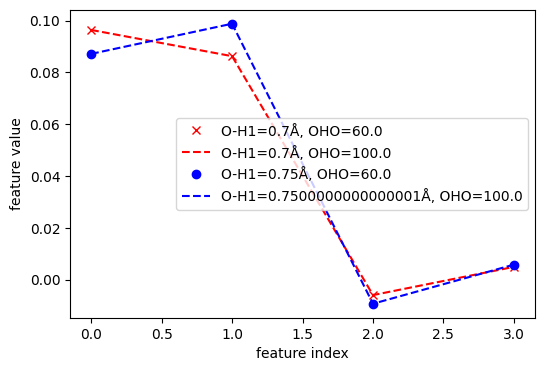

In [13]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
block = rhoi.block(spherical_harmonics_l=0, species_center=8, species_neighbor=1)
y = block.values
ax.plot(y[0,0], 'rx', label=f"O-H1={h2o_frames[0].info['OH1']}Å, OHO={h2o_frames[0].info['HOH']}")
ax.plot(y[4,0], 'r--', label=f"O-H1={h2o_frames[4].info['OH1']}Å, OHO={h2o_frames[4].info['HOH']}")
ax.plot(y[11,0], 'bo', label=f"O-H1={h2o_frames[11].info['OH1']}Å, OHO={h2o_frames[11].info['HOH']}")
ax.plot(y[15,0], 'b--', label=f"O-H1={h2o_frames[15].info['OH1']}Å, OHO={h2o_frames[15].info['HOH']}")
ax.set_xlabel('feature index')
ax.set_ylabel('feature value')
ax.legend()

$l=1$ components on the other hand are sensitive to the position of neighbors.
Overall, for a sufficiently fine-grained discretization of the density, the expansion coefficients contain full information on the position of all neighbors in 3D space. 

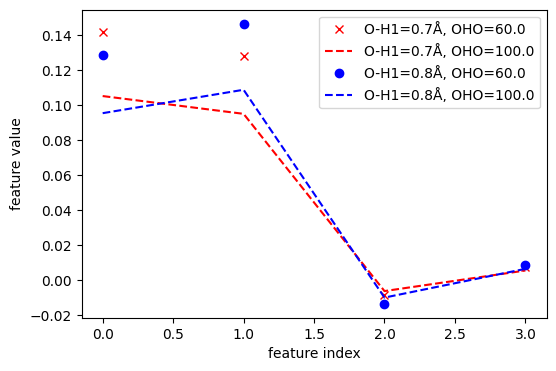

In [14]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
block = rhoi.block(spherical_harmonics_l=1, species_center=8, species_neighbor=1)
y = block.values
ax.plot(y[0,0], 'rx', label=f"O-H1={h2o_frames[0].info['OH1']:.1}Å, OHO={h2o_frames[0].info['HOH']}")
ax.plot(y[4,0], 'r--', label=f"O-H1={h2o_frames[4].info['OH1']:.1}Å, OHO={h2o_frames[4].info['HOH']}")
ax.plot(y[11,0], 'bo', label=f"O-H1={h2o_frames[11].info['OH1']:.1}Å, OHO={h2o_frames[11].info['HOH']}")
ax.plot(y[15,0], 'b--', label=f"O-H1={h2o_frames[15].info['OH1']:.1}Å, OHO={h2o_frames[15].info['HOH']}")
ax.set_xlabel('feature index')
ax.set_ylabel('feature value')
ax.legend()

## Computing information content with the GFRE

Given the possibility of having different types of descriptors, an obvious question is which choice of features provides the "best" representation of a set of structures. 
One possible answer is given by the "feature reconstruction error" metrics ([Goscinski et al., MLST (2021)](http://doi.org/10.1088/2632-2153/abdaf7)), that measures the error made by a linear model that attempts to predict features $\mathbf{X}'$ starting from an alternative featurization $\mathbf{X}$. 
Features are standardized so that complete failure in reconstructing the target representation yields a reconstruction error around 1. 

In [15]:
# we restrict the analysis to O-centered features, so there is one environment per structure. 
# we use `metatensor` utilities to consolidate l,m indices in the property block, and select exclusively 
# the blocks associated with O centers and H neighbors
block = (rhoi.components_to_properties(["spherical_harmonics_m"])
             .keys_to_properties(["spherical_harmonics_l"])
             .block(species_center=8, species_neighbor=1))

First, we look how density-expansion coefficients compare with the naive descriptors based on the Cartesian coordinates of the H atoms 
relative to the O (which sits at the origin). 

Surprisingly (given that the density descriptors are computed from the positions!) the reconstruction error is larger when going from the 
positions to the coefficients than vice versa. This happens because the relationship between the two is highly non-linear: in fact, using a 
local version of the algorithm that only tries to perform a locally linear mapping shows that the two representations contain similar 
amounts of information. 

In [16]:
positions = np.array([f.positions.flatten() for f in h2o_frames])
h_positions = positions[3:] 

In [17]:
print(f"""
Global reconstruction error positions -> density coefficients: {global_reconstruction_error(positions, block.values):4f}
Global reconstruction error density coefficients -> positions: {global_reconstruction_error(block.values, positions):4f}

Local reconstruction error positions -> density coefficients: {local_reconstruction_error(positions, block.values, n_local_points=3):4f}
Local reconstruction error density coefficients -> positions: {local_reconstruction_error(block.values, positions, n_local_points=3):4f}
""")


Global reconstruction error positions -> density coefficients: 0.207318
Global reconstruction error density coefficients -> positions: 0.055457

Local reconstruction error positions -> density coefficients: 0.039321
Local reconstruction error density coefficients -> positions: 0.033520



Another useful case is looking for convergence of the density expansion. Here a linear framework is natural, even though one should keep in mind that the error is an indication of how well the discretization encodes the neighbor density information, which is redundant relative to the simple encoding of the _atomic positions_.

NB: the high->low resolution reconstruction error is _not_ zero because even the larger basis is not fully converged and the GTO basis changes with the `max_radial` parameter so the larger basis does not contain explicitly the small-basis functions

In [18]:
# update the hypers to increase the number of channels
fine_calculator = rascaline.SphericalExpansion(**{**hypers, "max_radial":12, "max_angular":8})
fine_rhoi = fine_calculator.compute(h2o_frames)
fine_block = fine_rhoi.components_to_properties(["spherical_harmonics_m"]).keys_to_properties(["spherical_harmonics_l"]).block(species_center=8, species_neighbor=1)

mid_calculator = rascaline.SphericalExpansion(**{**hypers, "max_radial":6, "max_angular":4})
mid_rhoi = mid_calculator.compute(h2o_frames)
mid_block = mid_rhoi.components_to_properties(["spherical_harmonics_m"]).keys_to_properties(["spherical_harmonics_l"]).block(species_center=8, species_neighbor=1)

In [19]:
print(f"""
Global reconstruction error high-> low resolution: {global_reconstruction_error(fine_block.values, block.values):4f}
Global reconstruction error low -> high resolution: {global_reconstruction_error(block.values, fine_block.values):4f}
Global reconstruction error mid -> high resolution: {global_reconstruction_error(mid_block.values, fine_block.values):4f}
""")


Global reconstruction error high-> low resolution: 0.001055
Global reconstruction error low -> high resolution: 0.547158
Global reconstruction error mid -> high resolution: 0.154662



<a id="soap"> </a>

# Compute the SOAP representation

The $l=0$ part of the density-expansion coefficients $\langle an00|\rho_i\rangle$ corresponds to a discretization of the pair correlation function: using a real-space basis,

$$
    \langle ax00|\rho_i\rangle \approx \sum_{j\in A_i} \delta_{a a_j} \langle x | r_{ji} \rangle 
$$

where $ \langle x | r_{ji} \rangle $ is a localized function centered on $r_{ji}$. 

In order to obtain a richer description of the atomic environment it is possible to combine several copies of $\langle a\mathbf{x} | \rho_i \rangle$, to build $\nu$-neighbors atom-centered density correlations (ACDCs). 
The formalism we use was introduced by [Willatt et al.](https://doi.org/10.1063/1.5090481), and is explained in detail, discussing its relation with the leading frameworks for atomistic machine learning, in a [review by Musil et al.](https://doi.org/10.1021/acs.chemrev.1c00021)

Essentially, the idea is that considering tensor products of the atom density provides simultaneous information on the mutual position of several neighbors

$$
\langle \mathbf{x} |  \rho_i \rangle \langle \mathbf{x}' |  \rho_i \rangle =
\sum_{jj'\in A_i}
\langle \mathbf{x} |\mathbf{r}_{ji} \rangle \langle \mathbf{x}' |\mathbf{r}_{j'i} \rangle. 
$$

The invariant part of this two-neighbor correlation function can be extracted by taking a symmetrized product of the density coefficients,
$$
\langle aa'nn'l|\overline{\rho_i^{\otimes 2}}\rangle \propto 
\sum_m  \langle anlm|\rho_i\rangle \langle a'n'lm|\rho_i\rangle
$$


`rascaline` provides the infrastructure to evaluate SOAP features using the `SoapPowerSpectrum` calculator. We can compare the results with those obtained by explicitly computing the symmetrized products. 

In [20]:
soap_calculator = rascaline.SoapPowerSpectrum(**hypers)

In [21]:
rho2i = soap_calculator.compute(h2o_frames)

The calculator returns only invariant features, with separate blocks depending on the nature of the central atom and the neighbors. 
Select the block corresponding to O-centered $\langle HHnn'(l=2)|$ features

In [22]:
rho2i

TensorMap with 6 blocks
keys: species_center  species_neighbor_1  species_neighbor_2
            1                 1                   1
            1                 1                   8
                               ...
            8                 1                   8
            8                 8                   8

In [23]:
soap_OHH = rho2i.block(species_center=8, species_neighbor_1=1, species_neighbor_2=1)
soap_OHH_l2 = soap_OHH.values[:,np.where(soap_OHH.properties["l"]==2)[0]]

... and now compute the same manually. Note the $1/\sqrt{2l+1}$ factor.

In [24]:
rhoi_OH = rhoi.blocks(species_center=8, species_neighbor=1)

In [25]:
manual_OHH_l2 = np.einsum("imn, imp-> inp", rhoi_OH[2].values, rhoi_OH[2].values).reshape(len(h2o_frames),-1)/np.sqrt(5.)

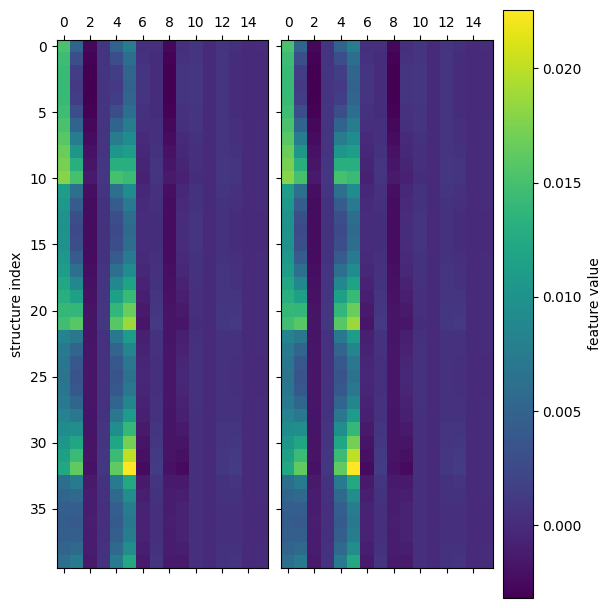

In [26]:
fig, ax = plt.subplots(1,2,figsize=(6,6), sharex=True, sharey=True, constrained_layout=True)
ax[0].matshow(soap_OHH_l2[:40])
ax[0].set_ylabel("structure index")
cbvals=ax[1].matshow(manual_OHH_l2[:40])
fig.colorbar(cbvals, label="feature value");

<a id="variations"> </a>

# Relation between density correlation features, real-space neighbor-density and atom-centered symmetry functions

The purpose of this (rather contrieved) demonstration is to show explicitly the relation between density expansion coefficients and a smooth neighbor density, and between SOAP descriptors and atom-centered symmetry functions. 
We use `SphericalBesselBasis` (the Laplacian Eigenvalues basis from [Bigi et al., JCP (2022)](http://doi.org/10.1063/5.0124363)) because it's orthonormal and makes it easier to post-process based on the utility functions in `rascaline`. 

## Density reconstruction

We can explicitly plot the real-space neighbor density by computing it from the coefficients:

$$
\rho_i(\mathbf{x}) = \sum_{nlm} R_{nl}(x) Y_l^m(\hat{\mathbf{x}}) \langle nlm | \rho_i \rangle
$$

We use `SoapSpliner` to compute the radial integrals that enter the calculation of the density expansion. As explained e.g. in [Musil et al., JCP (2021)](http://doi.org/10.1063/5.0044689), the coefficients for the expansion when using a Gaussian smearing with standard deviation $\sigma$ can be computed by evaluating at the neighbor positions a suitably-computed radial integral function $R_nl^{(\sigma)}$. 

$$
 \langle nlm | \rho_i \rangle = \sum_{j\in A_i} R_{nl}^{(\sigma)}(r_{ji}) Y_l^m(\hat{\mathbf{r}}_{ji}),
$$

However, when reconstructing the density one needs to use the bare (non-smoothed) functions 

In [27]:
hypers = {
    "cutoff": 4,
    "max_radial": 4,
    "max_angular": 16,
    "atomic_gaussian_width": 0.3,
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
    "center_atom_weight": 1.0
}

basis_functions = rascaline.utils.SphericalBesselBasis(hypers["cutoff"], hypers["max_radial"], hypers["max_angular"])

basis_integrals = rascaline.utils.SoapSpliner(
    cutoff=hypers["cutoff"],
    max_radial=hypers["max_radial"],
    max_angular=hypers["max_angular"],
    basis=basis_functions,
    density=rascaline.utils.GaussianDensity(atomic_gaussian_width=hypers["atomic_gaussian_width"]),
    accuracy=1e-4
).compute()

hypers["radial_basis"] = basis_integrals

Nice twist: we use `selected_keys` to only compute one set of element-element density coefficients, between O and H

In [28]:
calculator = rascaline.SphericalExpansion(**hypers)
rhoi_oh = calculator.compute(h2o_frames, 
                      selected_keys=mt.Labels(["spherical_harmonics_l", "species_center", "species_neighbor"],
                                              np.array([[l,8,1] for l in range(hypers["max_angular"])]  ) )
                             )

In [29]:
# a utility function to compute the density projected on a list of 3D points
def real_space_rho(x, cnlm, hypers):
    sph = sc.SphericalHarmonics(l_max=hypers["max_angular"], normalized=True).compute(x)    
    values = np.zeros(x.shape[0])
    for key, block in cnlm.items():
        l = key["spherical_harmonics_l"]
        for n in range(hypers["max_radial"]):
            rbf = basis_functions.compute(n, l, np.sqrt(np.sum(x**2,axis=1)) )
            sph_l = (sph[:, l*l:(l+1)*(l+1)] @ block.values[0, :, n])
        values += rbf*sph_l
    return values

Now we compute the reconstructed density. 
NB: instabilities in the orthogonalization procedure for the basis make it difficult to converge the expansion

In [30]:
ngrid = 100
iframe = 15
grid = np.array(list(itertools.product(np.linspace(-1.5,1.5,ngrid), np.linspace(-1.5,1.5,ngrid), [0])) 
               ).reshape(-1,3)
# this selects the coefficients for a single structure 
cnlm = mt.slice(rhoi_oh, axis="samples", labels=Labels("structure", np.array([[iframe]])))
rbf = real_space_rho(grid, cnlm, hypers)

Text(0, 0.5, 'y / Å')

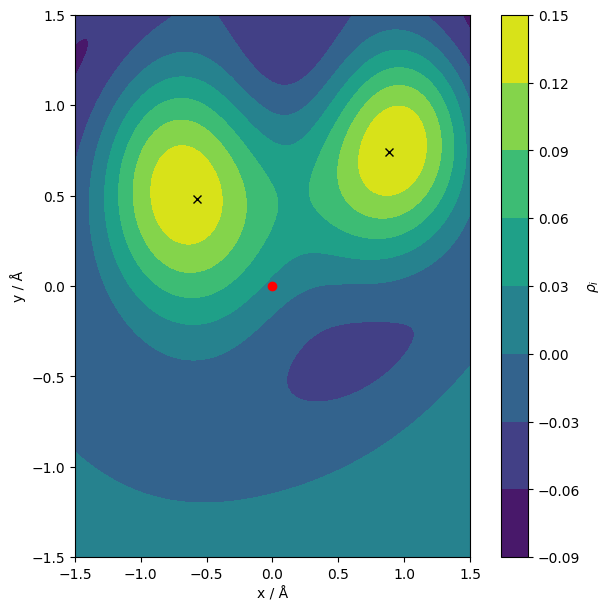

In [31]:
fig, ax = plt.subplots(1,1,figsize=(6,6), constrained_layout=True)
ctf = ax.contourf(grid[:,0].reshape(ngrid,ngrid), grid[:,1].reshape(ngrid,ngrid), 
             rbf.reshape(ngrid,ngrid))
fig.colorbar(ctf, label=r'$\rho_i$')
ax.plot(h2o_frames[iframe].positions[1:,0], h2o_frames[iframe].positions[1:,1], 'kx')
ax.plot(h2o_frames[iframe].positions[:1,0], h2o_frames[iframe].positions[:1,1], 'ro')
ax.set_xlabel('x / Å')
ax.set_ylabel('y / Å')

## Density coefficients and atom-centered symmetry functions

We now demonstrate another link between density correlations and a widely-used family of descriptors, atom-centered symmetry functions. 

In the Dirac-$\delta$ limit of Gaussian smearing, the expansion coefficients are just the radial functions evaluated at the atomic positions, and one can show that

$$
\langle nn'l|\overline{\rho_i^{\otimes 2}}\rangle \propto
\sum_{jj'\in A_i} R_{nl}(r_{ji}) R_{nl}(r_{j'i}) P_l(\hat{\mathbf{r}}_{ji}\cdot \hat{\mathbf{r}}_{j'i})
$$

let's see this in action

In [41]:
hypers = {
    "cutoff": 4,
    "max_radial": 4,
    "max_angular": 16,
    "atomic_gaussian_width": 0.3,
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
    "center_atom_weight": 1.0
}

basis_functions = rascaline.utils.SphericalBesselBasis(hypers["cutoff"], hypers["max_radial"], hypers["max_angular"])

basis_integrals = rascaline.utils.SoapSpliner(
    cutoff=hypers["cutoff"],
    max_radial=hypers["max_radial"],
    max_angular=hypers["max_angular"],
    basis=basis_functions,
    density=rascaline.utils.DeltaDensity(),  # <<< we evaluate with a delta density
    accuracy=1e-5
).compute()

hypers["radial_basis"] = basis_integrals

We compute only the OHH component of the SOAP power spectrum

In [42]:
soap_calculator = rascaline.SoapPowerSpectrum(**hypers)
rhoi_ohh = soap_calculator.compute(h2o_frames, 
                    selected_keys=mt.Labels(["species_center", "species_neighbor_1", "species_neighbor_2"],
                                           np.array([[8,1,1]]))
                                   )

We now compute explicitly the symmetry functions, summing over all pairs of neighbors

In [43]:
def acsf(r_list, l, n, n1, Rnl):
    """ Compute ACSF based on the Rnl radial functions 
    
    r_list: list of neighbor positions (n_neigbors, 3)
    l: angular momentum channel
    n, n1: the two radial channels
    Rnl: the basis function from rascaline.utils
    """
    
    value = 0.0
    Rnl_list = []
    Rn1l_list = []    
    for rij in r_list:
        Rnl_list.append(Rnl.compute(n=n, ell=l, integrand_positions=np.sqrt(rij@rij)))
        Rn1l_list.append(Rnl.compute(n=n1, ell=l, integrand_positions=np.sqrt(rij@rij)))
    for rij, R in zip(r_list, Rnl_list):    
        for rijp, Rp in zip(r_list, Rn1l_list):
            cosjjp = rij@rijp/np.sqrt((rij@rij) *(rijp@rijp))
            value += R*Rp*np.polynomial.legendre.legval(cosjjp, [0]*l+[1])
    return value

In [45]:
# accumulate the reference (SOAP-based) and manual (computed ACSF) values for all structures and channels
ref_manual = np.zeros((
    len(h2o_frames), 
    len(rhoi_ohh.block(0).properties),
    2))

for i in range(len(h2o_frames)):    
    for j, p in enumerate(rhoi_ohh.block(0).properties):
        # Note how we use the properties keys to keep track of what each property is 
        ref_manual[i,j] =  (
          rhoi_ohh.block(0).values[i,j],
          acsf(h2o_frames[i].positions[1:],p["l"],p["n1"],p["n2"],basis_functions), 
        )

We disregard a bunch of normalization and scaling coefficients, so the density correlations and ACSF descriptors are only proportional and not identical

Text(0, 0.5, 'ACSF')

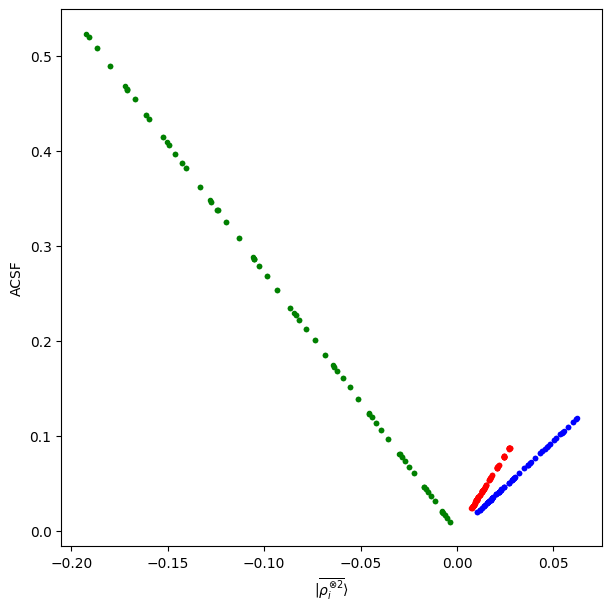

In [46]:
fig, ax = plt.subplots(1,1,figsize=(6,6), constrained_layout=True)
ax.plot(ref_manual[:,22,0], ref_manual[:,22,1], 'g.')
ax.plot(ref_manual[:,33,0], ref_manual[:,33,1], 'r.')
ax.plot(ref_manual[:,44,0], ref_manual[:,44,1], 'b.')
ax.set_xlabel(r"$|\overline{\rho_i^{\otimes 2}}\rangle$")
ax.set_ylabel("ACSF")

<a id="variations"> </a>

# Equivariance: a primer

_Equivariance_ indicates the property of a function for which the inputs and outputs are subject to the action of the same symmetries, and which commutes with the application of the symmetries, that is: $f(\hat{S}A) = \hat{S} f(A)$. _Invariance_ can be seen as a special case, in which  $f(\hat{S}A) = f(A)$.
This section focuses in particular on the case of 3D rotations and inversion - in technical terms the $O(3)$ group symmetries - and their combination with translations - the three-dimensional Euclidean group $E(3)$. 

## Rotations and vectors

Let's now start looking into how a vector such as the dipole moment rotates. The key concept is that a vectorial property such as the atomic positions or the dipole moment transform, under the action of a rotation operation $\hat{R}$ in a way consistent with the application of a rotation matrix $\mathbf{R}$, i.e. if a structure $A$ has atomic positions $\mathbf{r}_i$ and dipole moment $\mathbf{y}_i$ (each of these being a 3-vector corresponding to the Cartesian coordinates $(x,y,z)$) then the rotated structure $\hat{R}A$ has atomic coordinates $\mathbf{R}\mathbf{r}_i$ and dipole moment $\mathbf{R}\mathbf{y}$. 

We begin generating a dataset of rotated molecules, rotating also the dipoles

In [13]:
rotated_structures = []
rotated_wdipole = []
# this is the reference molecule we use 
selected_frame = h2o_frames[81].copy()
selected_dipole = h2o_dipole[81].copy()
selected_frame.info['alpha'] = 0
selected_frame.info['beta'] = 0
selected_frame.info['gamma'] = 0
for alpha in np.linspace(0, 2*np.pi, 8):
    for beta in np.linspace(0, np.pi, 4):
        for gamma in np.linspace(0, 2*np.pi, 8):
            rot_frame = selected_frame.copy() 
            rot_frame.info['alpha'] = alpha
            rot_frame.info['beta'] = beta
            rot_frame.info['gamma'] = gamma
            # rotates the frame
            R = rotation_matrix(alpha, beta, gamma)
            rot_frame.positions = rot_frame.positions@R.T
            rot_frame.cell = rot_frame.cell@R.T
            rot_frame.info['dipole'] = rot_frame.info['dipole']@R.T
            rotated_structures.append(rot_frame)            

In [14]:
dipole_arrows = chemiscope.ase_vectors_to_arrows(rotated_structures, "dipole", scale=4, head_length_scale=3);
dipole_arrows["parameters"]["global"].update({ "color": 0x60A0FF })
cs = chemiscope.show(rotated_structures, properties = chemiscope.extract_properties(rotated_structures),
        shapes={ "dipole" : dipole_arrows},
        settings={
            'map' : { 'x':{'property' : "alpha"},  'y':{'property' : "beta"}, 'z' : {'property' : 'gamma'},
                      'color' : {'property': "dipole[1]"} },
            'structure': [{'axes': 'off','keepOrientation': True, 'shape': ['dipole']}]
        })

if chemiscope.jupyter._is_running_in_notebook():
    from IPython.display import display
    display(cs)

<ChemiscopeWidget(meta={'name': ' '}, settings={'map': {'x': {'property': 'alpha'}, 'y': {'property': 'beta'},…

<a id="spherical-tensors"> </a>

## Rotations and arbitrary tensors

Vectorial quantities such as the dipole $\mathbf{y}$ are just one of the possible types of equivariant properties associated with a molecular structure. We consider as an example the tensor

$$
\mathbf{Y} = \mathbf{y}\mathbf{y}^T + |\mathbf{y}|^2 \mathbf{1}/2,  
$$

built starting from the dipole moment. 

In [15]:
def y_to_Y(y):
    return y.reshape(-1,1)@y.reshape(1,-1) + 0.5* (y@y)*np.eye(3)

In [16]:
selected_frame.info['Y'] = y_to_Y(selected_frame.info['dipole'])
for rot_frame in rotated_structures:
    rot_frame.info['Y'] = y_to_Y(rot_frame.info['dipole'])

This quantity transforms under rotation as $\mathbf{Y}(\hat{R}A) = \mathbf{R}\mathbf{Y}(A)\mathbf{R}^T$. 
While this is a perfectly fine way of expressing the transformation, it is more complicated than necessary: all the $9$ components of $\mathbf{Y}$ are formally mixed in the process, and even though it is linear in $\mathbf{Y}$, to explicitly cast it as such requires combining the two multiplications by $\mathbf{R}$ into the multiplication by a large, $9\times 9$ matrix.

In [17]:
# picks one of the rotated structures
test_frame = rotated_structures[21]
selected_Y = selected_frame.info['Y']
test_Y = test_frame.info['Y']
# builds the rotation matrix
R = rotation_matrix(test_frame.info['alpha'], test_frame.info['beta'], test_frame.info['gamma'])

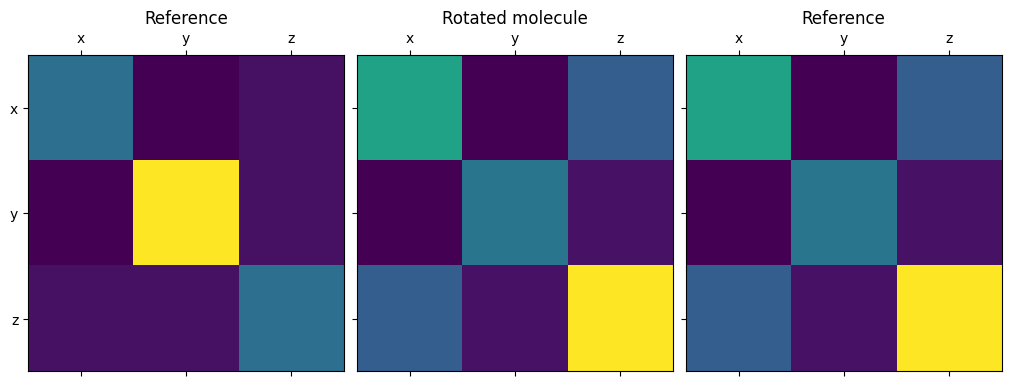

In [18]:
fig, ax = plt.subplots(1,3,figsize=(10,4), sharey=True, constrained_layout=True)
ax[0].matshow(selected_Y)
# rotated Y matches the Y of the rotated structure
ax[1].matshow(test_Y)
ax[2].matshow(R@selected_Y@R.T)

ax[0].set_title("Reference")
ax[1].set_title("Rotated molecule")
ax[2].set_title("Reference")

for axi in ax:
    axi.set_xticks(np.arange(3))
    axi.set_xticklabels(['x', 'y', 'z'])
    axi.set_yticks(np.arange(3))
    axi.set_yticklabels(['x', 'y', 'z'])

In [19]:
# builds the 9x9 rotation matrix - can you follow the index juggling?
flat_idx = np.array([(0,0),(0,1),(0,2),(1,0),(1,1),(1,2),(2,0),(2,1),(2,2)], dtype=int)
RR = R[flat_idx[:,0]][:,flat_idx[:,0]]*R[flat_idx[:,1]][:,flat_idx[:,1]]

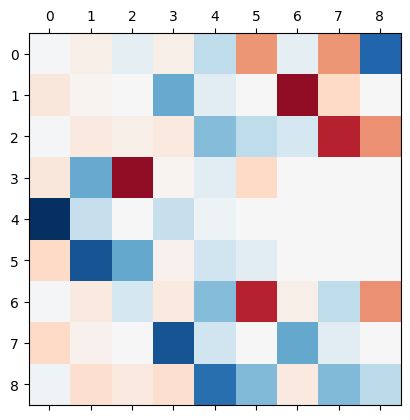

In [20]:
# the 9x9 matrix is almost entirely full
plt.matshow(RR, cmap=plt.cm.RdBu, vmin=-max(np.abs(RR.flatten())), vmax=max(np.abs(RR.flatten())))

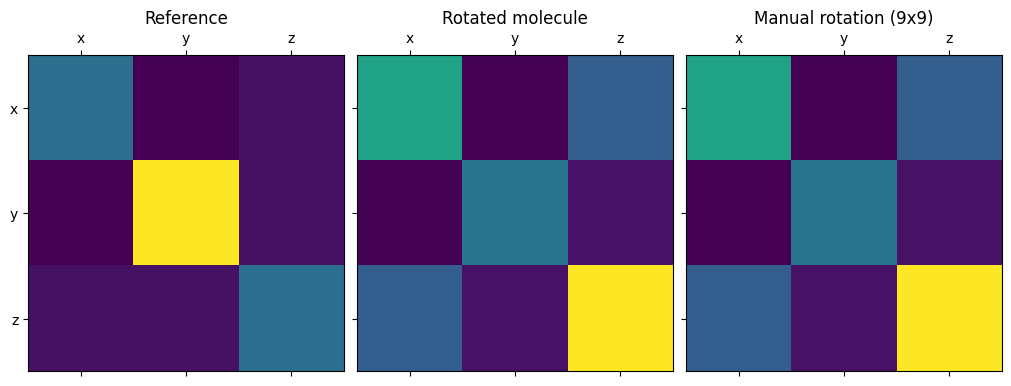

In [21]:
# the 9x9 matrix rotates the tensor with a single multiplication
rotated_9x9=(RR@(selected_Y[flat_idx[:,0],flat_idx[:,1]])).reshape(3,3)

fig, ax = plt.subplots(1,3,figsize=(10,4), sharey=True, constrained_layout=True)
ax[0].matshow(selected_Y)
# rotated Y matches the Y of the rotated structure
ax[1].matshow(test_Y)
ax[2].matshow(rotated_9x9)

ax[0].set_title("Reference")
ax[1].set_title("Rotated molecule")
ax[2].set_title("Manual rotation (9x9)")

for axi in ax:
    axi.set_xticks(np.arange(3))
    axi.set_xticklabels(['x', 'y', 'z'])
    axi.set_yticks(np.arange(3))
    axi.set_yticklabels(['x', 'y', 'z'])
    


This brings us to the concept of _irreducible_ representations of the rotation group. In very hand-wavy terms, we look for ways to simplify the transformation by recombining entries in $\mathbf{Y}$ so that they are less mixed up when acted upon by a rotation $\hat{R}$. 
That this might be possible can be seen by noticing that the _trace_ of $\mathbf{Y}$, $Y_{xx}+Y_{yy}+ Y_{zz}$ is left unchanged by the rotation: it is _invariant_!

In [22]:
print(np.trace(test_Y), np.trace(selected_Y))

0.40527335997463276 0.4052733599746325


It turns out that products of Cartesian coordinates can be rearranged into blocks that transform under rotation as _spherical harmonics_, $Y^m_l$. The theory is not entirely trivial, and gets even messier if (as we do here) one wants to express everything in terms of _real_ quantities. 
The manipulations here are somewhat opaque (and rely heavily on utility functions) but allow to follow the construction of the _spherical tensor_ form of $\mathbf{Y}$. 

In [23]:
# we need Clebsch-Gordan coefficients to transform the Cartesian tensor into an irreducible form
cg = ClebschGordanReal(l_max=2)
# xyz_to_spherical transforms Cartesian coordinates into a form consistent 
# with the definition of l=1 real spherical harmonics we use 
cg.couple(xyz_to_spherical(selected_Y))

{(1, 1): {0: array([-0.23398468]),
  1: array([0., 0., 0.]),
  2: array([-0.01584898,  0.        , -0.06618086,  0.        , -0.11352766])}}

The output indicates that the tensor was built as the product of two vector-like ($l=1$) spherical Harmonics, and it has been decomposed into a scalar ($l=0$), pseudo-vector ($l=1$, zero because the tensor is symmetric), and higher-order ($l=2$) term. Each block contains $2m+1$ components. We can therefore stack these in a a single array with 9 components, that could (in principle) be written as a unitary transformation of the initial Cartesian form.

In [24]:
def to_coupled(cartesian):
    coupled = cg.couple(xyz_to_spherical(cartesian))
    return np.hstack( [coupled[(1,1)][l] for l in [0,1,2]] )
selected_coupled_Y = to_coupled(selected_Y)
test_coupled_Y = to_coupled(test_Y)
# note that elements [1:4] are zero: this is a consequence of the symmetry of Y
print(selected_coupled_Y)
print(test_coupled_Y)

[-0.23398468  0.          0.          0.         -0.01584898  0.
 -0.06618086  0.         -0.11352766]
[-0.23398468  0.          0.          0.          0.01748918  0.03029216
  0.07917508  0.09690396  0.02524021]


Compare the $9\times 9$ matrix above with that associated with rotating the tensor in this new basis. Each of the irreducible blocks transform separately, so the rotation matrix is block-diagonal. _Any_ Cartesian tensor can be expressed in terms of a collection of $Y^m_l$-like irreducible blocks.

In [25]:
# the rotation matrix for the irreducible form can be built from a collection
# of (real-valued) Wigner D matrices
coupled_RR = np.zeros((9,9))
coupled_RR[0,0] = wigner_d_real(0, test_frame.info['alpha'], test_frame.info['beta'], test_frame.info['gamma'])
coupled_RR[1:4,1:4] = wigner_d_real(1, test_frame.info['alpha'], test_frame.info['beta'], test_frame.info['gamma'])
coupled_RR[4:9,4:9] = wigner_d_real(2, test_frame.info['alpha'], test_frame.info['beta'], test_frame.info['gamma'])

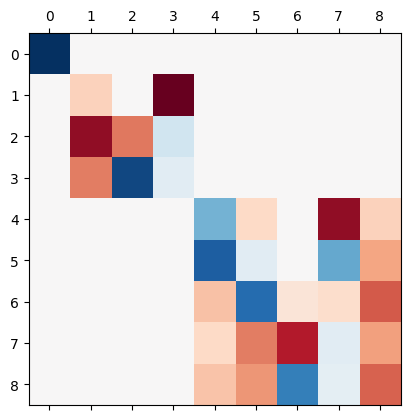

In [26]:
# the 9x9 matrix is block diagonal
plt.matshow(coupled_RR, cmap=plt.cm.RdBu, vmin=-max(np.abs(RR.flatten())), vmax=max(np.abs(RR.flatten())))

In [27]:
# this block-diagonal matrix performs a rotation in the irreducible spherical basis
print(selected_coupled_Y)
print(coupled_RR@selected_coupled_Y)
print(test_coupled_Y)

[-0.23398468  0.          0.          0.         -0.01584898  0.
 -0.06618086  0.         -0.11352766]
[-0.23398468  0.          0.          0.          0.01748918  0.03029216
  0.07917508  0.09690396  0.02524021]
[-0.23398468  0.          0.          0.          0.01748918  0.03029216
  0.07917508  0.09690396  0.02524021]


The transformation can be reverted to bring the rotated tensor back to its Cartesian form

In [28]:
coupled = {(1,1): {0:test_coupled_Y[:1], 1:test_coupled_Y[1:4], 2: test_coupled_Y[4:9]}}
rotated_spherical2xyz = spherical_to_xyz(cg.decouple(coupled))

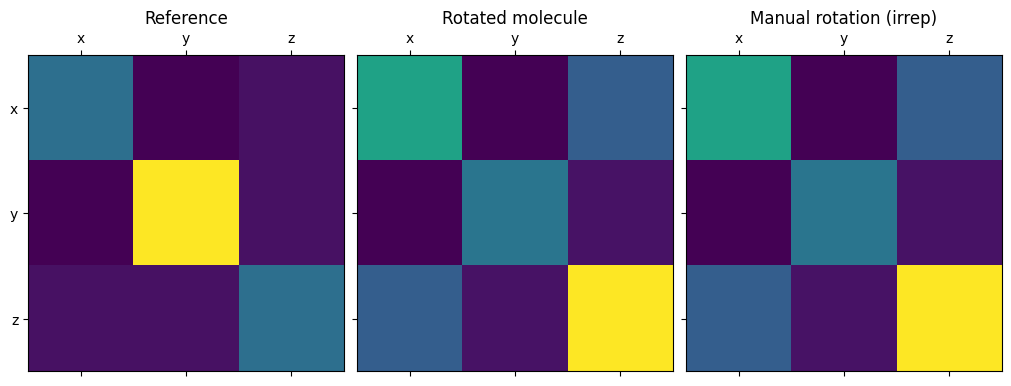

In [29]:
# the 9x9 matrix rotates the tensor with a single multiplication
rotated_9x9=(RR@(selected_Y[flat_idx[:,0],flat_idx[:,1]])).reshape(3,3)

fig, ax = plt.subplots(1,3,figsize=(10,4), sharey=True, constrained_layout=True)
ax[0].matshow(selected_Y)
# rotated Y matches the Y of the rotated structure
ax[1].matshow(test_Y)
ax[2].matshow(rotated_spherical2xyz)

ax[0].set_title("Reference")
ax[1].set_title("Rotated molecule")
ax[2].set_title("Manual rotation (irrep)")

for axi in ax:
    axi.set_xticks(np.arange(3))
    axi.set_xticklabels(['x', 'y', 'z'])
    axi.set_yticks(np.arange(3))
    axi.set_yticklabels(['x', 'y', 'z'])

## Equivariance of the density coefficients

Let's now see how the density coefficients actually behave as equivariant descriptors. This is kind of obvious given that we build them by expanding the density on a basis of spherical harmonics! Here we compute descriptors for two of the rotated structures, and see how the same result can be achieved by applying the rotation to the base molecule using a Wigner-D matrix.

In [30]:
hypers = {
    "cutoff": 3,
    "max_radial": 4,
    "max_angular": 3,
    "atomic_gaussian_width": 0.1,
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
    "radial_basis": {"Gto":  {"spline_accuracy": 1e-6 }},
    "center_atom_weight": 1.0
}

In [31]:
calculator = rascaline.SphericalExpansion(**hypers)

In [32]:
selected_rhoi = calculator.compute([selected_frame])
test_rhoi = calculator.compute([test_frame])
selected_rhoi = selected_rhoi.keys_to_properties('species_neighbor')
test_rhoi = test_rhoi.keys_to_properties('species_neighbor')

In [69]:
# pick just one block as example
selected_block = selected_rhoi.block(spherical_harmonics_l=3, species_center=8).values[0]
test_block = test_rhoi.block(spherical_harmonics_l=3, species_center=8).values[0]

In [70]:
test_block

ExternalCpuArray([[ 0.06048793,  0.0672177 , -0.01358698,  0.0051843 ,
                    0.        ,  0.        ,  0.        ,  0.        ],
                  [-0.00565351,  0.05868458,  0.0070544 ,  0.00063225,
                    0.        ,  0.        ,  0.        ,  0.        ],
                  [ 0.04272501,  0.09492376, -0.00537262,  0.00447748,
                    0.        ,  0.        ,  0.        ,  0.        ],
                  [ 0.06787539,  0.09076079, -0.0138811 ,  0.00608106,
                    0.        ,  0.        ,  0.        ,  0.        ],
                  [-0.01407671, -0.04821182,  0.0002621 , -0.00176636,
                    0.        ,  0.        ,  0.        ,  0.        ],
                  [ 0.08762675,  0.11717168, -0.01792042,  0.00785061,
                    0.        ,  0.        ,  0.        ,  0.        ],
                  [ 0.06972682,  0.10082465, -0.0135841 ,  0.00637737,
                    0.        ,  0.        ,  0.        ,  0.        ]]

In [72]:
wd = wigner_d_real(3, test_frame.info['alpha'], test_frame.info['beta'], test_frame.info['gamma'])

In [73]:
wd @ selected_block

array([[ 0.06048793,  0.0672177 , -0.01358698,  0.0051843 ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [-0.00565351,  0.05868458,  0.0070544 ,  0.00063225,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.04272501,  0.09492376, -0.00537262,  0.00447748,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.06787539,  0.09076079, -0.0138811 ,  0.00608106,  0.        ,
         0.        ,  0.        ,  0.        ],
       [-0.01407671, -0.04821182,  0.0002621 , -0.00176636,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.08762675,  0.11717168, -0.01792042,  0.00785061,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.06972682,  0.10082465, -0.0135841 ,  0.00637737,  0.        ,
         0.        ,  0.        ,  0.        ]])

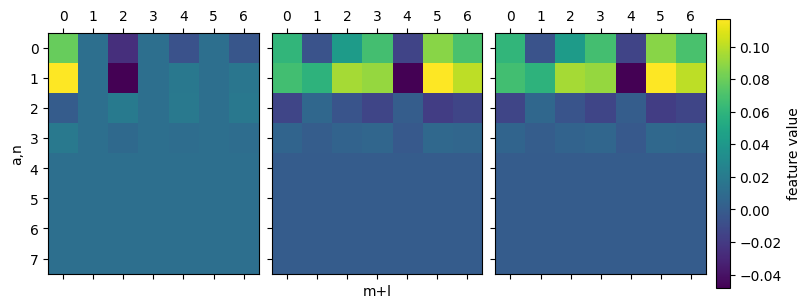

In [76]:
fig, ax = plt.subplots(1,3,figsize=(8,3), sharex=True, sharey=True, constrained_layout=True)
ax[0].matshow(selected_block.T)
ax[1].set_xlabel("m+l")
ax[0].set_ylabel("a,n")
ax[1].matshow(test_block.T)
cbvals = ax[2].matshow((wd@ selected_block).T)
fig.colorbar(cbvals, label="feature value");

In light of this, we can see density coefficients as _symmetry adapted_ descriptors. To emphasize their equivariant behavior, and that they reflect the distribution of neighbors by summing over them one of a time, we indicate the coefficients as 

$$
\langle an|\overline{\rho_i^{\otimes 1}; \lambda \mu }\rangle \equiv
\langle an\lambda \mu|\rho_i\rangle
$$

## Clebsch-Gordan iteration and equivariant correlations

In order to obtain a richer description of the atomic environment it is possible to combine several copies of $\langle a\mathbf{x} | \rho_i \rangle$, to build $\nu$-neighbors atom-centered density correlations (ACDCs). 
The formalism we use was introduced by [Willatt et al.](https://doi.org/10.1063/1.5090481), and is explained in detail, discussing its relation with the leading frameworks for atomistic machine learning, in a [review by Musil et al.](https://doi.org/10.1021/acs.chemrev.1c00021)

Essentially, the idea is that considering tensor products of the atom density provides simultaneous information on the mutual position of several neighbors

$$
\langle \mathbf{x} |  \rho_i \rangle \langle \mathbf{x}' |  \rho_i \rangle =
\sum_{jj'\in A_i}
\langle \mathbf{x} |\mathbf{r}_{ji} \rangle \langle \mathbf{x}' |\mathbf{r}_{j'i} \rangle. 
$$

Much like for the case of Cartesian tensors, these tensor products can be re-cast in terms of irreducible representations of the O(3) (rotations + inversion) group. A (comparatively) simple and efficient way to obtain these equivariant ACDC features is to build them iteratively, as discussed e.g. by [Nigam et al. ](https://doi.org/10.1063/5.0021116), using an expression that corresponds to the combination of angular momenta in quantum mechanics using Clebsch-Gordan coefficients $\langle k m_1\  l m_2 | \lambda \mu \rangle$.

$$
\langle q k;  a n l|\overline{\rho_i^{\otimes (\nu+1)}; \sigma (-1)^{l+k+\lambda};  \lambda \mu } \rangle = 
\sum_{m_1 m_2} 
\langle q |\overline{\rho_i^{\otimes \nu}; k m_1 } \rangle
\langle a n|\overline{\rho_i^{\otimes 1}; \sigma; l m_2 } \rangle 
\langle k m_1\  l m_2 | \lambda \mu \rangle.
$$

The additional index $\sigma$ in the ket $|\sigma; \lambda \mu>$ takes the values $\pm 1$ and tracks the parity of the descriptors with respect to inversion (all the $\nu=1$ equivariants have a parity $+1$, which means that they pick up a phase $(-1)^\lambda$ under inversion).

Here we show a demonstration of how to compute these symmetrized correlations, and demonstrate that they are rotationally-equivariant

In [83]:
# pick just one block as example
l1, l2, L = 3, 2, 4

selected_block_a = selected_rhoi.block(spherical_harmonics_l=l1, species_center=8).values[0]
selected_block_b = selected_rhoi.block(spherical_harmonics_l=l2, species_center=8).values[0]

test_block_a = test_rhoi.block(spherical_harmonics_l=l1, species_center=8).values[0]
test_block_b = test_rhoi.block(spherical_harmonics_l=l2, species_center=8).values[0]

Compute a tensor of Clebsch-Gordan coefficients  $\langle k m_1\  l m_2 | \lambda \mu \rangle$. The three indices are $m_1$, $m_2$, $\mu$. 
The CG tensors are actually very sparse for $l$ values greater than two; for complex-valued spherical harmonics, the condition for having a non-zero coefficient is just that $m_1+m_2=\mu$ - but here we are working with real-valued spherical harmonics, which is reflected in the form of the coefficients. 
See `utils.py` if you are curious to see how this tensor is computed. 

In [85]:
cg_full = _real_clebsch_gordan_matrix(l1, l2, L)
print(cg_full[0])

[[ 0.          0.          0.         -0.14638501  0.          0.
   0.          0.          0.        ]
 [ 0.54772256  0.          0.3105295   0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.67082039  0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -0.3105295   0.          0.54772256]
 [ 0.          0.          0.          0.          0.          0.14638501
   0.          0.          0.        ]]


Now we combine the blocks with the CG product. Again, this is very inefficient, one should use a sparse version that combines only the non-zero coefficients. 

In [79]:
selected_block_ab = np.einsum('mn,pq,mpM->Mnq', selected_block_a, selected_block_b, cg_full).reshape(2*L+1,-1)
test_block_ab = np.einsum('mn,pq,mpM->Mnq', test_block_a, test_block_b, cg_full).reshape(2*L+1,-1)

Demonstrate that these coefficients transform like order-$\lambda$ spherical harmonics

In [80]:
wd = wigner_d_real(L, test_frame.info['alpha'], test_frame.info['beta'], test_frame.info['gamma'])

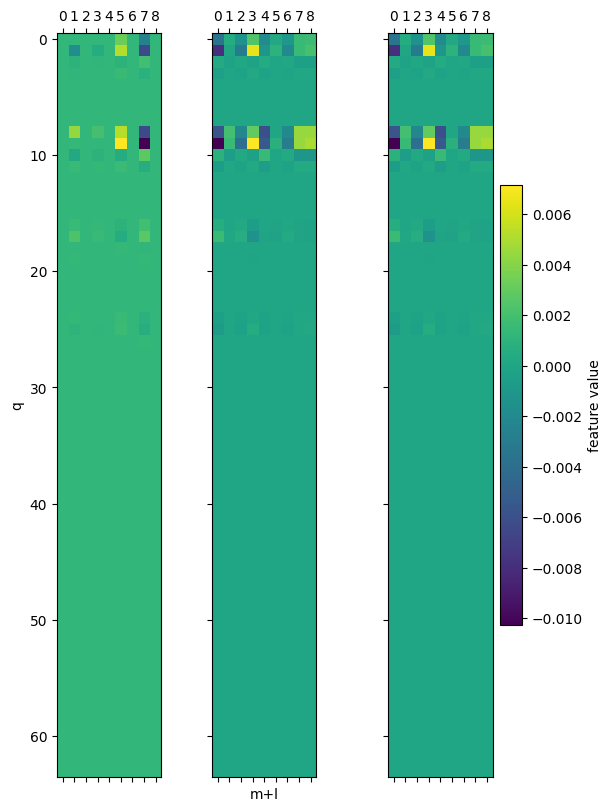

In [81]:
fig, ax = plt.subplots(1,3,figsize=(6,8), sharex=True, sharey=True, constrained_layout=True)
ax[0].matshow(selected_block_ab.T)
ax[1].set_xlabel("m+l")
ax[0].set_ylabel("q")
ax[1].matshow(test_block_ab.T)
cbvals = ax[2].matshow((wd@ selected_block_ab).T)
fig.colorbar(cbvals, label="feature value");